In [4]:
import os
import numpy as np
from safetensors.torch import load_file
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def load_safetensor_weights(folder_path, layer_filter=None):
    """
    Loads all weights from safetensors in a folder.
    Returns: dict[layer_name] -> flattened numpy array
    """
    weights = {}

    for file in os.listdir(folder_path):
        if file.endswith(".safetensors"):
            tensor_path = os.path.join(folder_path, file)
            tensors = load_file(tensor_path)

            for name, tensor in tensors.items():
                if layer_filter and layer_filter not in name:
                    continue
                if tensor.ndim == 0:
                    continue

                weights.setdefault(name, []).append(
                    tensor.detach().cpu().numpy().ravel()
                )

    # concatenate per layer
    for k in weights:
        weights[k] = np.concatenate(weights[k])

    return weights


In [5]:
def apply_plotly_theme(fig, mode="dark"):
    mode = mode.lower()

    if mode == "dark":
        bg_color = "#0e1117"
        grid_color = "#2a2f3a"
        text_color = "white"
        template = "plotly_dark"
    else:
        bg_color = "white"
        grid_color = "rgba(0,0,0,0.08)"
        text_color = "black"
        template = "plotly_white"

    fig.update_layout(
        template=template,
        paper_bgcolor=bg_color,
        plot_bgcolor=bg_color,
        font=dict(color=text_color),
        legend=dict(
            bgcolor=bg_color,
            bordercolor=grid_color,
            borderwidth=1,
        ),
    )

    fig.update_xaxes(
        showgrid=True,
        gridcolor=grid_color,
        zeroline=False,
        color=text_color,
    )

    fig.update_yaxes(
        showgrid=True,
        gridcolor=grid_color,
        zeroline=False,
        color=text_color,
    )


In [6]:
def plot_weight_box_compare(
    parent_folder,
    model_folders,
    layer_keyword=None,
    title="Weight Distribution Comparison (Box Plot)",
    bg='dark'
):
    """
    Each subplot = one model
    Each subplot contains box plots of that model's layers
    """

    model_weights = {}

    for model in model_folders:
        path = os.path.join(parent_folder, model)
        w = load_safetensor_weights(path, layer_filter=layer_keyword)
        if w:
            model_weights[model] = w

    if not model_weights:
        print("No weights found.")
        return None

    n_models = len(model_weights)

    fig = make_subplots(
        rows=1,
        cols=n_models,
        subplot_titles=list(model_weights.keys()),
        shared_yaxes=True
    )

    for col_idx, (model_name, layers) in enumerate(model_weights.items(), start=1):
        for layer_name, w in layers.items():
            fig.add_trace(
                go.Box(
                    y=w,
                    name=layer_name,
                    boxmean=True,
                    showlegend=(col_idx == 1)  # show legend only once
                ),
                row=1,
                col=col_idx
            )

        # X-axis label per subplot
        fig.update_xaxes(
            title_text="Layers",
            tickangle=45,
            row=1,
            col=col_idx
        )

    fig.update_layout(
        title=title,
        yaxis_title="Weight Value",
        boxmode="group",
        height=600
    )

    return fig


In [7]:
import os
import json
import plotly.graph_objects as go

# -------------------------------------------------------
# Load logs.json
# -------------------------------------------------------
def load_logs(run_folder):
    json_path = os.path.join(run_folder, "logs.json")

    if not os.path.exists(json_path):
        print(f"❌ logs.json missing in: {run_folder}")
        return None

    with open(json_path, "r") as f:
        return json.load(f)


# -------------------------------------------------------
# Generic plot function (single metric)
# -------------------------------------------------------
def create_plot(data_dict, x_key, y_key, title, bg="dark"):
    fig = go.Figure()

    for model_label, logs in data_dict.items():
        x = logs.get(x_key, [])
        y = logs.get(y_key, [])

        if len(x) == 0 or len(y) == 0:
            print(f"Missing data for {model_label} → {y_key}")
            continue

        fig.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode="lines+markers",
                name=model_label
            )
        )

    fig.update_layout(
        title=title,
        xaxis_title=x_key,
        yaxis_title=y_key,
        hovermode="x unified",
    )

    apply_plotly_theme(fig, bg)
    return fig



# -------------------------------------------------------
# Train vs Validation Loss plot (epoch-wise)
# -------------------------------------------------------
def create_train_val_loss_plot(data_dict, title, bg="dark"):
    fig = go.Figure()

    # Plotly default qualitative colors (clean & standard)
    COLOR_PALETTE = [
        "#1f77b4", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]

    max_epoch = 0

    for idx, (model_label, logs) in enumerate(data_dict.items()):
        x = logs.get("epoch_index", [])
        train_loss = logs.get("epoch_train_losses", [])
        val_loss = logs.get("epoch_val_losses", [])

        if len(x) == 0 or len(train_loss) == 0 or len(val_loss) == 0:
            print(f"Missing train/val loss data for {model_label}")
            continue

        # ---- Standard epoch indexing (start from 1) ----
        epochs = [i + 1 for i in x]
        max_epoch = max(max_epoch, epochs[-1])

        color = COLOR_PALETTE[idx % len(COLOR_PALETTE)]

        # ---- Train (solid) ----
        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=train_loss,
                mode="lines+markers",
                name=f"{model_label} - Train",
                line=dict(color=color, width=2.5),
                marker=dict(symbol="circle", size=7),
            )
        )

        # ---- Validation (dashed, same color) ----
        fig.add_trace(
            go.Scatter(
                x=epochs,
                y=val_loss,
                mode="lines+markers",
                name=f"{model_label} - Val",
                line=dict(color=color, width=2.5, dash="dash"),
                marker=dict(symbol="square", size=7),
            )
        )

    # ---- Standard layout & fixed scaling ----
    fig.update_layout(
        title=title,
        hovermode="x unified",
        legend=dict(font=dict(size=11)),

        xaxis=dict(
            title="Epoch",
            range=[1, max_epoch],
            tickmode="linear",
            dtick=1,
        ),

        yaxis=dict(
            title="Loss",
        ),
    )

    apply_plotly_theme(fig, bg)
    return fig





# -------------------------------------------------------
# Main comparison function
# -------------------------------------------------------
def compare_runs(parent_folder, run_names, graph_types=None, bg="dark"):
    bg = bg.lower()
    runs = {}

    for folder in run_names:
        run_path = os.path.join(parent_folder, folder)
        logs = load_logs(run_path)
        if logs:
            runs[folder[20::]] = logs

    if len(runs) == 0:
        print("No valid runs found.")
        return {}

    # ---------------------------------------------------
    # Compute cumulative times and indices
    # ---------------------------------------------------
    for logs in runs.values():
        # batch cumulative time
        cum, total = [], 0
        for t in logs.get("batch_times", []):
            total += t
            cum.append(total)
        logs["batch_cum_time"] = cum

        # epoch cumulative time
        cum, total = [], 0
        for t in logs.get("epoch_times", []):
            total += t
            cum.append(total)
        logs["epoch_cum_time"] = cum

        logs["batch_index"] = list(range(len(logs.get("batch_train_losses", []))))
        logs["epoch_index"] = list(range(len(logs.get("epoch_train_losses", []))))

    ALL_GRAPHS = {
        "batch_loss": ("batch_index", "batch_train_losses"),
        "batch_acc": ("batch_index", "batch_train_accs"),

        "batch_loss_time": ("batch_cum_time", "batch_train_losses"),
        "batch_acc_time": ("batch_cum_time", "batch_train_accs"),

        "epoch_train_loss": ("epoch_index", "epoch_train_losses"),
        "epoch_train_acc": ("epoch_index", "epoch_train_accs"),

        "epoch_val_loss": ("epoch_index", "epoch_val_losses"),
        "epoch_val_acc": ("epoch_index", "epoch_val_accs"),

        "epoch_train_loss_time": ("epoch_cum_time", "epoch_train_losses"),
        "epoch_val_loss_time": ("epoch_cum_time", "epoch_val_losses"),

        # NEW
        "epoch_train_vs_val_loss": None,
        "weight_box_compare": None,
    }

    if graph_types is None:
        graph_types = list(ALL_GRAPHS.keys())

    output_figures = {}

    for g in graph_types:
        if g not in ALL_GRAPHS:
            print(f"Unknown graph type ignored: {g}")
            continue

        if g == "epoch_train_vs_val_loss":
            fig = create_train_val_loss_plot(
                runs,
                title="Train vs Validation Loss (Epoch-wise)",
                bg=bg
            )

        elif g == "weight_box_compare":
            fig = plot_weight_box_compare(
                parent_folder=parent_folder,
                model_folders=run_names,
                layer_keyword="weight",
                title="Model Weight Distribution Comparison",
                bg=bg   # ← ADD THIS
            )

        else:
            x_key, y_key = ALL_GRAPHS[g]
            fig = create_plot(
                runs,
                x_key,
                y_key,
                title=f"Comparison: {g}",
                bg=bg
            )
        output_figures[g] = fig

    return output_figures


In [8]:
def apply_theme(ax, fig, mode="dark"):
    if mode.lower() == "dark":
        bg_color = "#0e1117"     # dark background
        grid_color = "#2a2f3a"
        text_color = "white"
    else:
        bg_color = "white"
        grid_color = "#d0d0d0"
        text_color = "black"

    # Figure + axes background
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # Axes labels & title
    ax.title.set_color(text_color)
    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)

    # Tick colors
    ax.tick_params(colors=text_color)

    # Spines
    for spine in ax.spines.values():
        spine.set_color(text_color)

    # Grid
    ax.grid(True, linestyle="--", alpha=0.3, color=grid_color)

    # Legend
    legend = ax.get_legend()
    if legend:
        legend.get_frame().set_facecolor(bg_color)
        legend.get_frame().set_edgecolor(grid_color)
        for text in legend.get_texts():
            text.set_color(text_color)


In [9]:
import os
import json
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Load logs.json
# -------------------------------------------------------
def load_logs(run_folder):
    json_path = os.path.join(run_folder, "logs.json")

    if not os.path.exists(json_path):
        print(f"❌ logs.json missing in: {run_folder}")
        return None

    with open(json_path, "r") as f:
        return json.load(f)

# -------------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.0,
    "figure.dpi": 300
})
# -------------------------------------------------------
# Generic plot function (single metric)
# -------------------------------------------------------
def create_plot(data_dict, x_key, y_key, title, bg="dark"):

    fig, ax = plt.subplots(figsize=(8, 5))

    for model_label, logs in data_dict.items():
        x = logs.get(x_key, [])
        y = logs.get(y_key, [])

        if len(x) == 0 or len(y) == 0:
            print(f"Missing data for {model_label} → {y_key}")
            continue

        ax.plot(x, y, label=model_label)

    ax.set_title(title)
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
    ax.legend(frameon=False, loc="best")

    apply_theme(ax, fig, bg)
    return fig


# -------------------------------------------------------
# Train vs Validation Loss plot (epoch-wise)
# -------------------------------------------------------
def create_train_val_loss_plot(data_dict, title, bg="dark"):

    fig, ax = plt.subplots(figsize=(8, 5))

    for model_label, logs in data_dict.items():
        x = logs.get("epoch_index", [])
        train_loss = logs.get("epoch_train_losses", [])
        val_loss = logs.get("epoch_val_losses", [])

        if len(x) == 0 or len(train_loss) == 0 or len(val_loss) == 0:
            print(f"Missing train/val loss data for {model_label}")
            continue

        ax.plot(x, train_loss, marker='o', linestyle='-',
                label=f"{model_label} - Train")
        ax.plot(x, val_loss, marker='s', linestyle='--',
                label=f"{model_label} - Val")

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.3)
    apply_theme(ax, fig, bg)
    return fig


# -------------------------------------------------------
# Main comparison function
# -------------------------------------------------------
def compare_runs(parent_folder, run_names, graph_types=None, bg='dark'):
    runs = {}
    bg = bg.lower()

    for folder, name in run_names:
        run_path = os.path.join(parent_folder, folder)
        logs = load_logs(run_path)
        if logs:
            runs[name] = logs

    if len(runs) == 0:
        print("No valid runs found.")
        return {}

    # Compute cumulative times and indices
    for logs in runs.values():
        # batch cumulative time
        cum, total = [], 0
        for t in logs.get("batch_times", []):
            total += t
            cum.append(total)
        logs["batch_cum_time"] = cum

        # epoch cumulative time
        cum, total = [], 0
        for t in logs.get("epoch_times", []):
            total += t
            cum.append(total)
        logs["epoch_cum_time"] = cum

        logs["batch_index"] = list(range(len(logs.get("batch_train_losses", []))))
        logs["epoch_index"] = list(range(len(logs.get("epoch_train_losses", []))))

    ALL_GRAPHS = {
        "batch_loss": ("batch_index", "batch_train_losses"),
        "batch_acc": ("batch_index", "batch_train_accs"),

        "batch_loss_time": ("batch_cum_time", "batch_train_losses"),
        "batch_acc_time": ("batch_cum_time", "batch_train_accs"),

        "epoch_train_loss": ("epoch_index", "epoch_train_losses"),
        "epoch_train_acc": ("epoch_index", "epoch_train_accs"),

        "epoch_val_loss": ("epoch_index", "epoch_val_losses"),
        "epoch_val_acc": ("epoch_index", "epoch_val_accs"),

        "epoch_train_loss_time": ("epoch_cum_time", "epoch_train_losses"),
        "epoch_val_loss_time": ("epoch_cum_time", "epoch_val_losses"),

        # NEW
        "epoch_train_vs_val_loss": None,
    }

    if graph_types is None:
        graph_types = list(ALL_GRAPHS.keys())

    output_figures = {}

    for g in graph_types:
        if g not in ALL_GRAPHS:
            print(f"Unknown graph type ignored: {g}")
            continue

        if g == "epoch_train_vs_val_loss":
            fig = create_train_val_loss_plot(
                runs,
                title="Train vs Validation Loss (Epoch-wise)",
                bg=bg
            )
        else:
            x_key, y_key = ALL_GRAPHS[g]
            fig = create_plot(
                runs,
                x_key,
                y_key,
                title=f"Comparison: {g}",
                bg=bg
            )

        output_figures[g] = fig

    return output_figures


In [14]:
run_names = [
    (
        "2025-12-29_01-31-52_url_embed_flat_mlp512_256_128_64_binary_v5",
        "MLP on URL Embeddings"
    ),
    (
        "2025-12-29_21-22-30_url_embed_residual_dilated_stride_cnn128_64_flat_mlp256_128_ln_gelu_do25_head_binary_v21",
        "Residual Multi-Kernel CNN"
    ),
    (
        "2025-12-30_20-56-56_temp_lstmv107",
        "Temporal BiLSTM"
    ),
    (
        "2025-12-31_03-06-22_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v25",
        "CNN + BiLSTM Hybrid"
    ),
    (
        "2026-01-01_12-18-08_sequise_excitation_lstm_2layer_AttenionPooling_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v26",
        "SE + Attention Pooling"
    ),
    (
        "2026-01-02_15-15-21_no_postional_embeding_DAP_ResMK_CNN_BiLSTM_CNN_K357Conv_LSTM32_FC64_64_Drop10_v27",
        "DAP + CNN + BiLSTM"
    ),
    (
        "2026-01-11_21-07-49_best model till now testing",
        "Proposed Best Hybrid Model"
    )
]


[('2025-12-29_01-31-52_url_embed_flat_mlp512_256_128_64_binary_v5', 'MLP on URL Embeddings'), ('2025-12-29_21-22-30_url_embed_residual_dilated_stride_cnn128_64_flat_mlp256_128_ln_gelu_do25_head_binary_v21', 'Residual Multi-Kernel CNN'), ('2025-12-30_20-56-56_temp_lstmv107', 'Temporal BiLSTM'), ('2025-12-31_03-06-22_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v25', 'CNN + BiLSTM Hybrid'), ('2026-01-01_12-18-08_sequise_excitation_lstm_2layer_AttenionPooling_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v26', 'SE + Attention Pooling'), ('2026-01-02_15-15-21_no_postional_embeding_DAP_ResMK_CNN_BiLSTM_CNN_K357Conv_LSTM32_FC64_64_Drop10_v27', 'DAP + CNN + BiLSTM'), ('2026-01-11_21-07-49_best model till now testing', 'Proposed Best Hybrid Model')]


C:\Users\rrpra\AppData\Local\Temp\ipykernel_17292\227601833.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figs[fig_name].show()


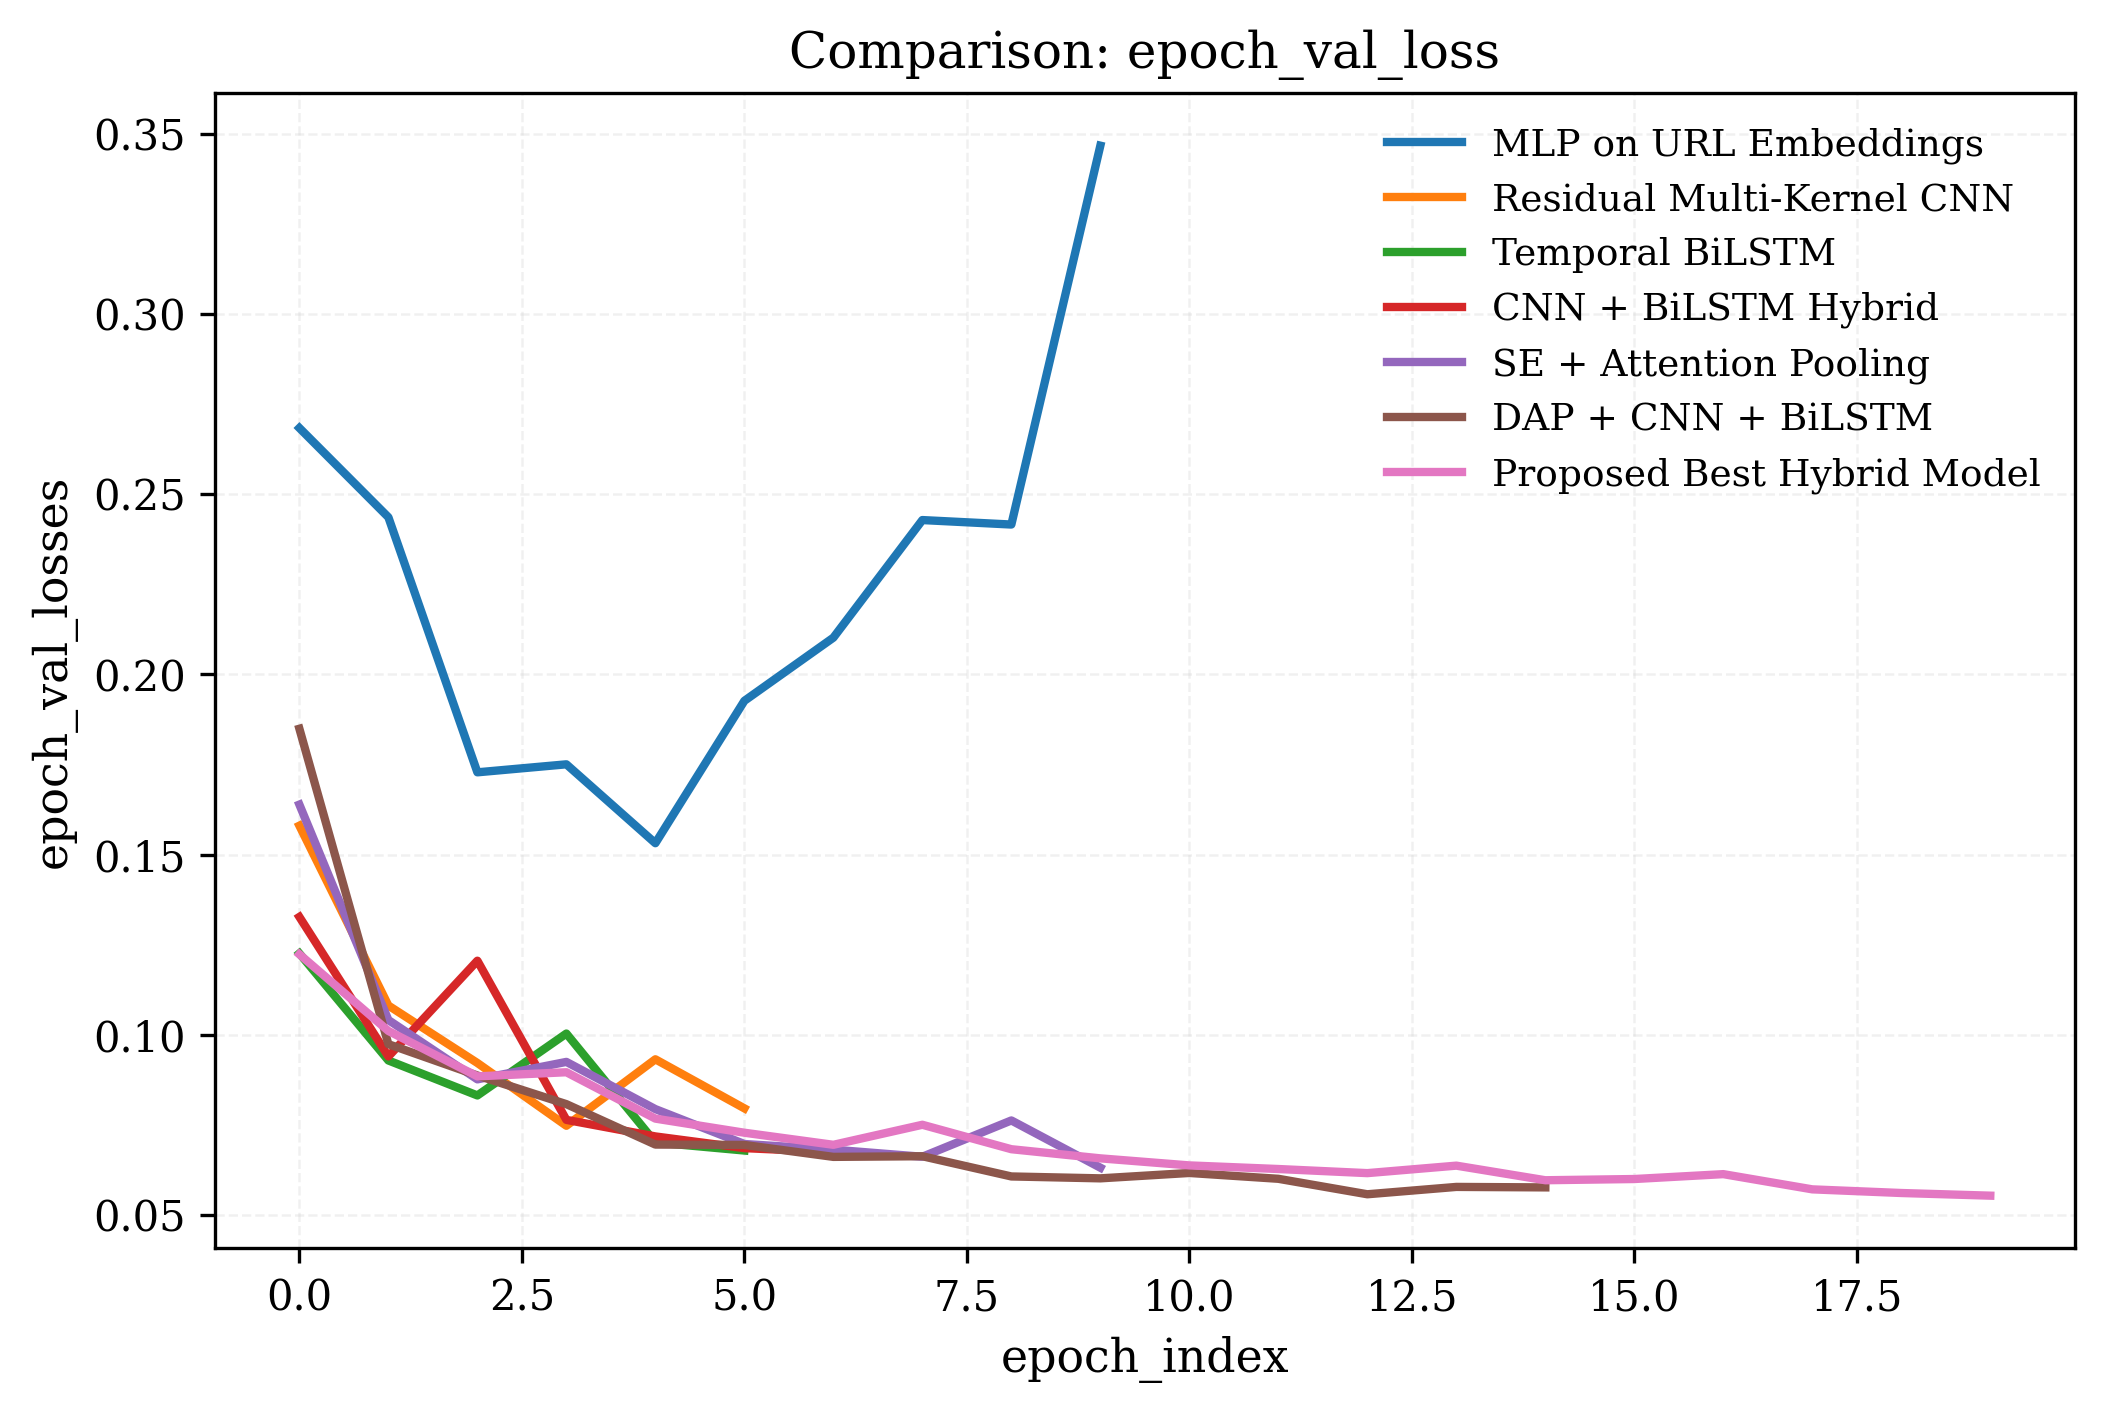

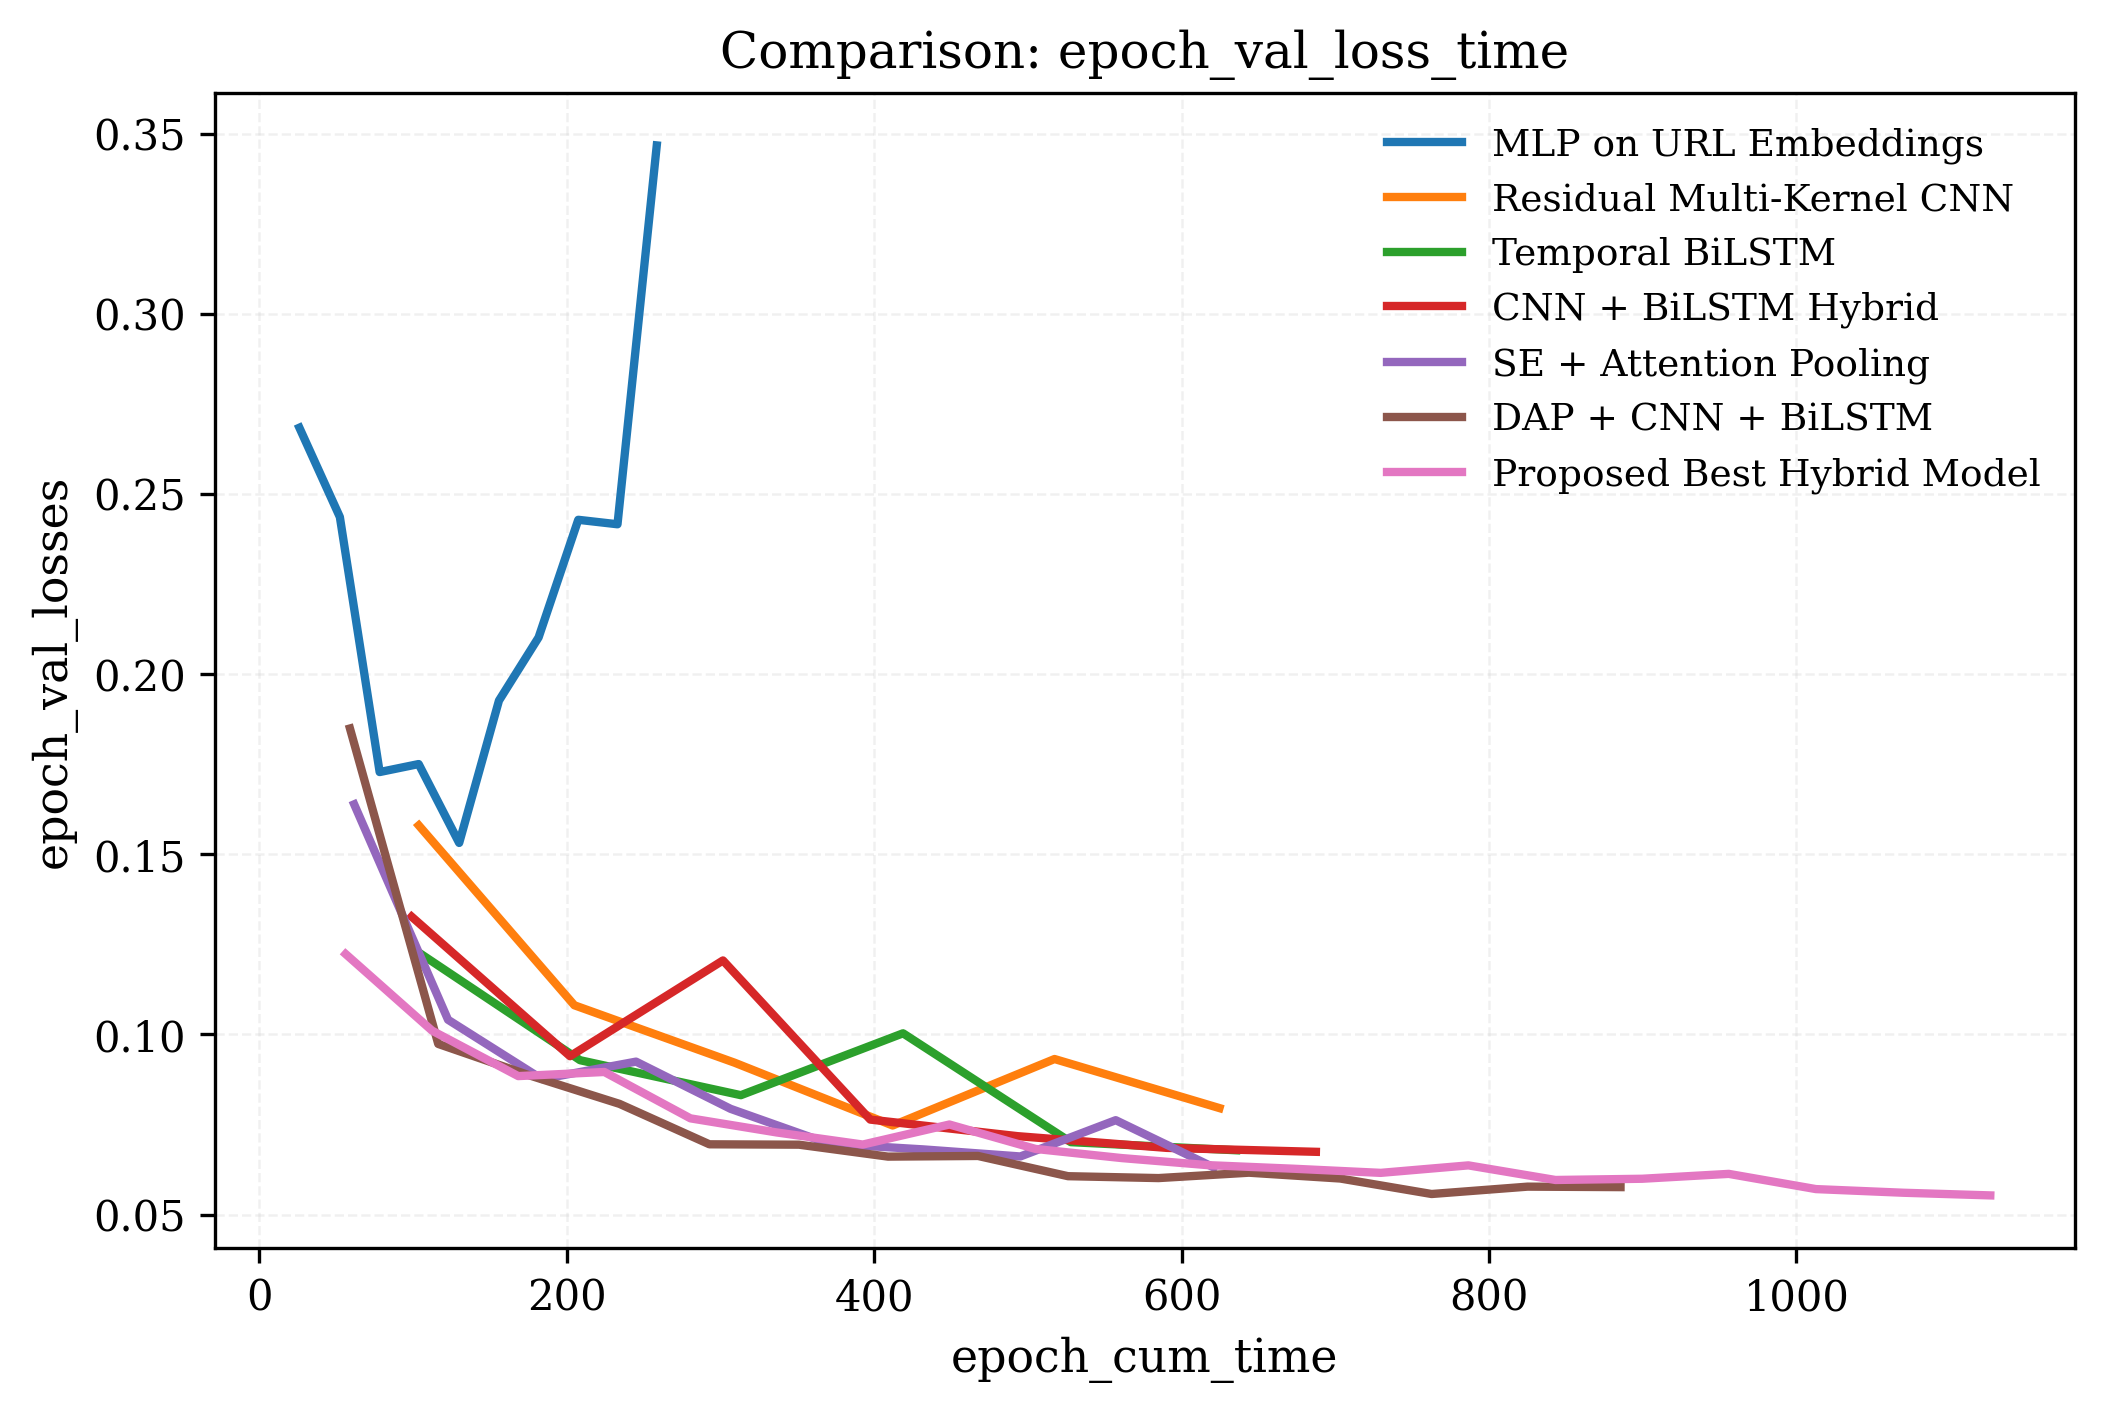

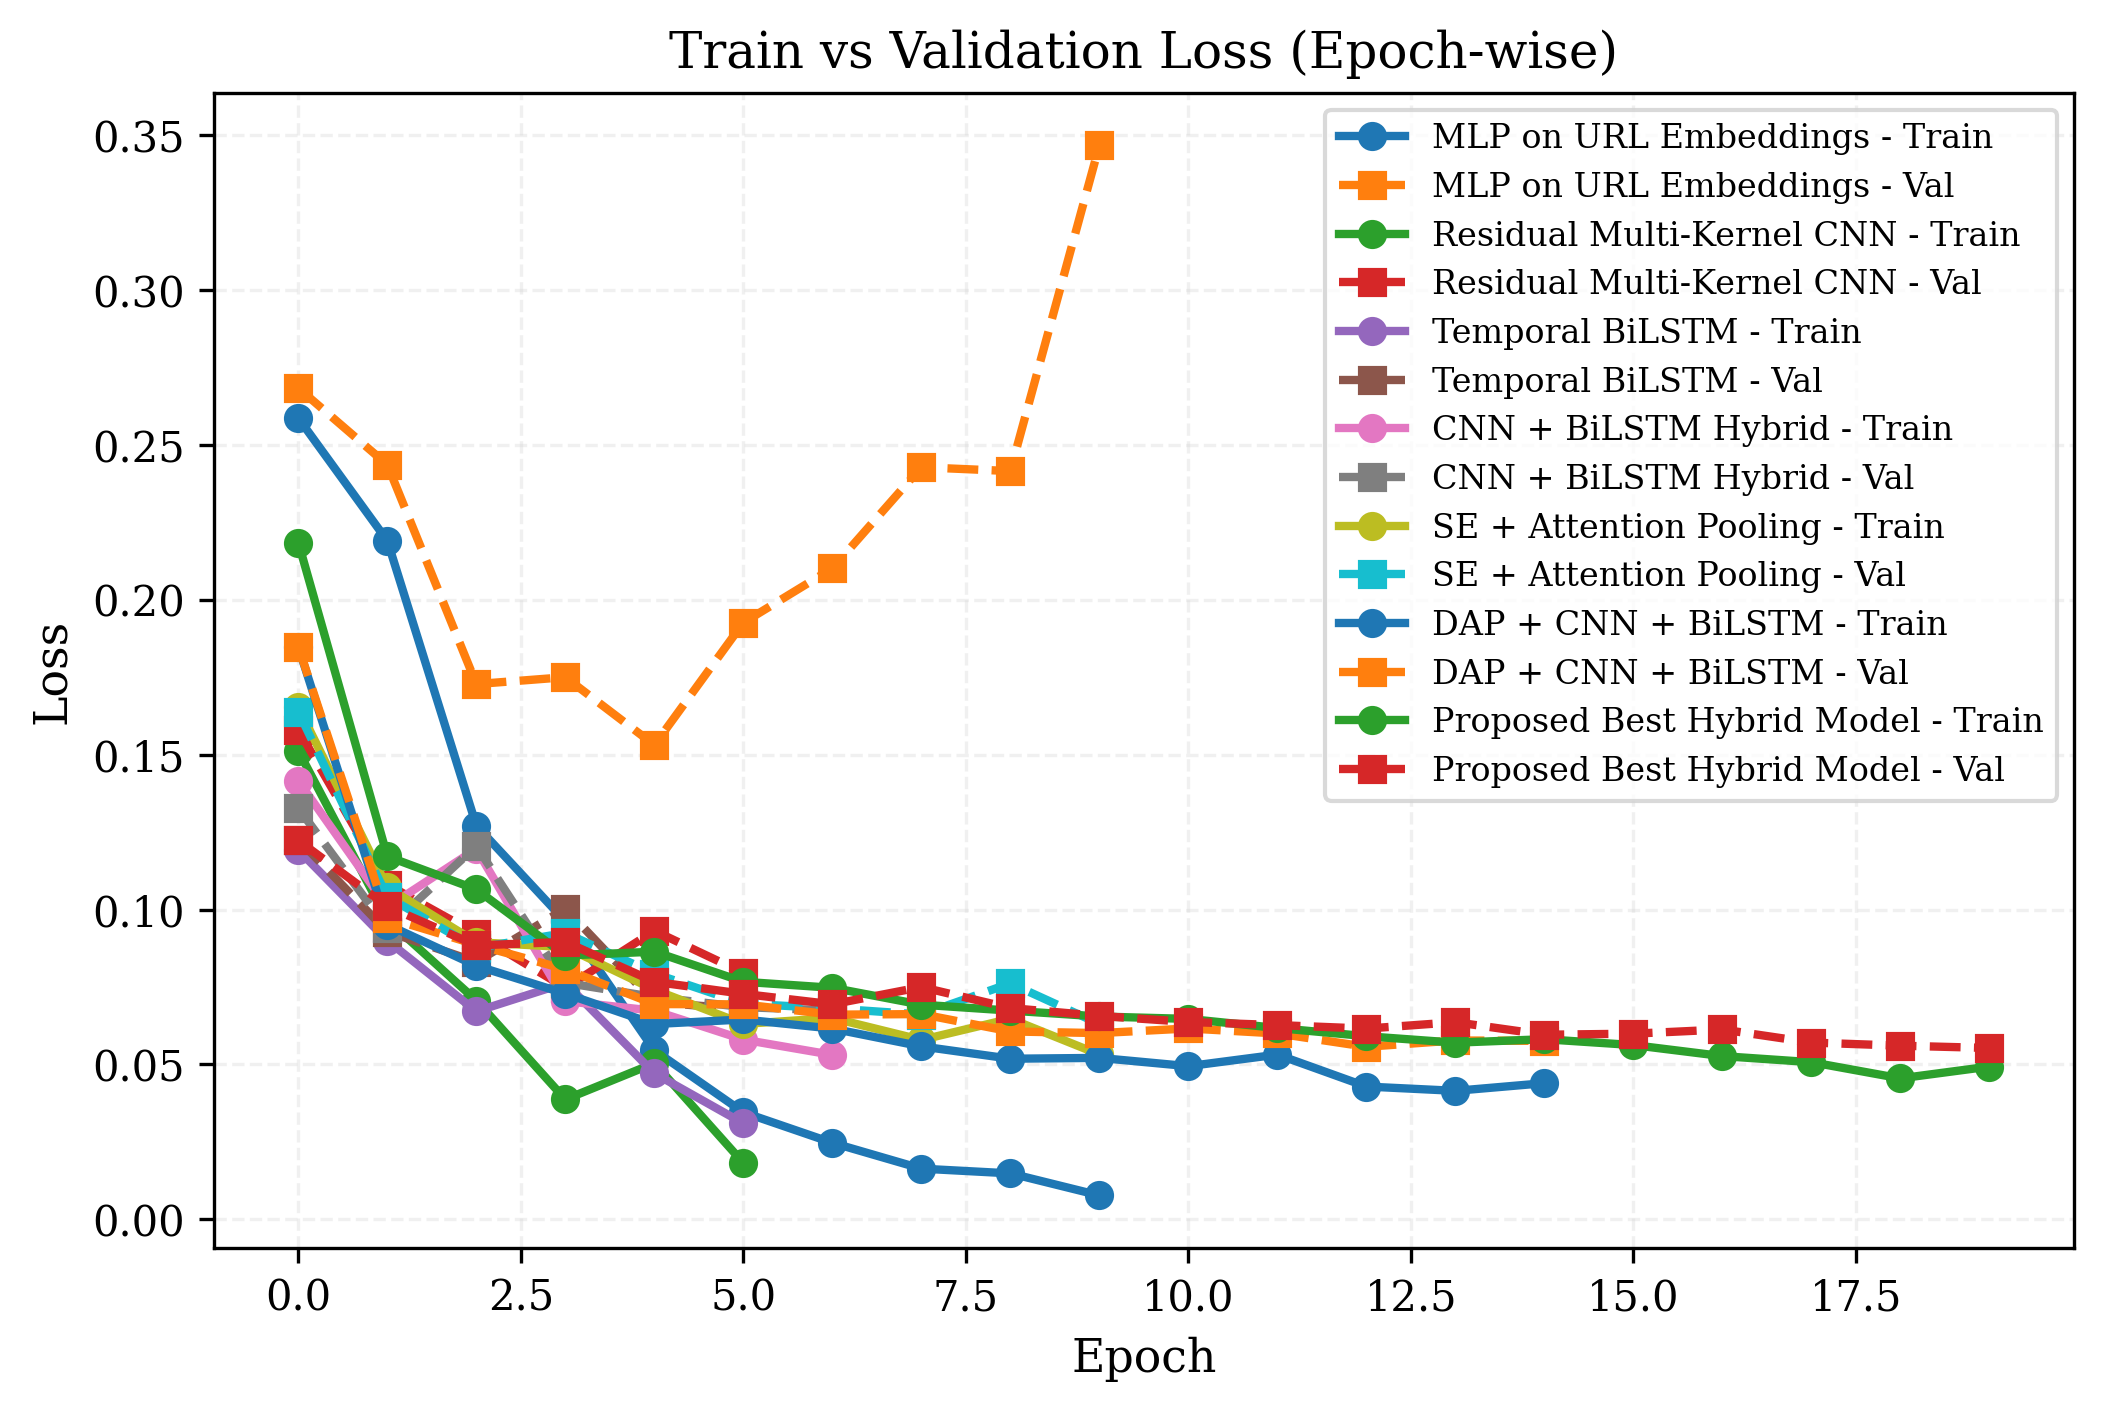

In [15]:
import os
parent_folder=r"training_runs"
#run_names = []

'''
search_filter = ''

for file in os.listdir(parent_folder):
    if search_filter in file and int(float(file.split('v')[-1])) in (26,27): #1202,20010,1310,
        run_names.append((file, file))

'''
print(run_names)
figs = compare_runs(
    parent_folder=parent_folder,
    graph_types=["epoch_val_loss", "epoch_val_loss_time","epoch_train_vs_val_loss"],
    run_names=run_names,
    bg='white'
)



# optional: show graphs
for fig_name in figs:
    figs[fig_name].show()



In [33]:
from collections import defaultdict
import numpy as np
def merge_layers(
    layer_weights: dict,
    depth: int = 2,
    merge_bias: bool = False
):
    """
    layer_weights: dict[layer_name -> np.ndarray]
    depth: how many name levels to keep
    """

    merged = defaultdict(list)

    for layer_name, weights in layer_weights.items():
        if not merge_bias and "bias" in layer_name:
            continue

        parts = layer_name.split(".")
        merged_name = ".".join(parts[:depth])

        merged[merged_name].append(weights)

    # concatenate merged groups
    merged = {
        k: np.concatenate(v)
        for k, v in merged.items()
    }

    return merged

def plot_weight_box_per_model(
    parent_folder,
    model_folders,
    layer_keyword=None,
    merge_depth=2,
    title_prefix="Weight Distribution"
):
    figures = {}

    for model in model_folders:
        path = os.path.join(parent_folder, model)
        weights = load_safetensor_weights(path, layer_filter=layer_keyword)

        if not weights:
            continue

        # 🔥 MERGE LAYERS HERE
        weights = merge_layers(weights, depth=merge_depth)

        fig = go.Figure()

        for layer_name, w in weights.items():
            fig.add_trace(
                go.Box(
                    y=w,
                    name=layer_name,
                    boxmean=True
                )
            )

        fig.update_layout(
            title=f"{title_prefix} – {model} (merged depth={merge_depth})",
            xaxis_title="Merged Layers",
            yaxis_title="Weight Value",
            boxmode="group",
            height=600
        )

        figures[model] = fig

    return figures


In [37]:

import os
parent_folder=r"training_runs"
run_names = []
search_filter = ''
for file in os.listdir(parent_folder):
    if search_filter in file and int(float(file.split('v')[-1])) in (26,): #1202,20010,1310,
        run_names.append(file)
print(run_names)
figs = plot_weight_box_per_model(
    parent_folder=parent_folder,
    model_folders=run_names,
    layer_keyword="weight"
)

# optional: show graphs
for fig_name in figs:
    figs[fig_name].show()

['2026-01-01_12-18-08_sequise_excitation_lstm_2layer_AttenionPooling_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v26', '2026-01-01_12-44-06_sequise_excitation_lstm_2layer_AttenionPooling_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v26', '2026-01-02_13-14-53_sequise_excitation_lstm_2layer_DualAttenionPooling_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v26', '2026-01-02_13-32-36_sequise_excitation_lstm_2layer_DualAttenionPooling_ResMK_CNN_BiLSTM_StridedCNN_K357_D12_2Conv_LSTM32x2_PostConvS2_FC64_64_Drop05_v26']


In [2]:
import os
import json

BASE_DIR = "./training_runs"   # root directory containing all experiment folders

results = []

def read_json(path):
    try:
        with open(path, "r") as f:
            return json.load(f)
    except:
        return None

results = []

for folder in sorted(os.listdir(BASE_DIR)):
    try:
        full_path = os.path.join(BASE_DIR, folder)
        if not os.path.isdir(full_path):
            continue

        test_metrics_path = os.path.join(full_path, "test_metrics.json")
        logs_path = os.path.join(full_path, "logs.json")

        test_acc = None
        val_acc = None
        train_acc = None
        total_time = None

        if os.path.exists(test_metrics_path):
            tm = read_json(test_metrics_path)
            if tm and "accuracy" in tm:
                test_acc = tm["accuracy"]

        if os.path.exists(logs_path):
            logs = read_json(logs_path)
            if logs:
                if "epoch_val_accs" in logs:
                    val_acc = logs["epoch_val_accs"][-1]
                if "epoch_train_accs" in logs:
                    try:
                        train_acc = logs["epoch_train_accs"][-1]
                    except:
                        train_acc = 0
                if "epoch_times" in logs:
                    total_time = sum(logs["epoch_times"])
        if val_acc > 0.97:
            results.append({
                "model": folder[:19:],
                "train_acc": train_acc,
                "val_acc": val_acc,
                "test_acc": test_acc,
                "total_time": total_time
            })

    except Exception as e:
        print(f"Error in {folder}: {e}")


# Print Table
print("\n=== ACCURACY SUMMARY ===\n")
for r in results:
    print(f"{r['model']}:  final_acc={r['train_acc']},"
          f"  test_acc={r['test_acc']}, val_acc={r['val_acc']}, total_time={r['total_time']}")



Error in 2025-12-29_03-06-34_url_embed_cnn128_256_128_64_flat_mlp512_256_ln_gelu_128_head_binary_v13: '>' not supported between instances of 'NoneType' and 'float'
Error in 2025-12-29_19-53-08_url_embed_residual_stride_cnn128_64_32_ds_flat_mlp512_256_ln_gelu_do50_128_head_binary_v16.2: '>' not supported between instances of 'NoneType' and 'float'
Error in 2025-12-29_23-10-58_temp_lstmv106: '>' not supported between instances of 'NoneType' and 'float'
Error in 2025-12-29_23-13-57_temp_lstmv107: '>' not supported between instances of 'NoneType' and 'float'
Error in 2025-12-30_20-35-51_temp_lstmv107: '>' not supported between instances of 'NoneType' and 'float'
Error in 2025-12-30_20-38-56_temp_lstmv107: '>' not supported between instances of 'NoneType' and 'float'
Error in 2026-01-01_10-52-06_previous_model_attension_pooling_less_dropout_more_parmsv1310.25: '>' not supported between instances of 'NoneType' and 'float'
Error in 2026-01-01_11-50-36_previous_model_sequise_excitation_Attenio

In [3]:
import pandas as pd

df = pd.DataFrame(results)
df = df.fillna(0.0)   # for clean plotting
import plotly.graph_objects as go
def make_bar(df_sorted):
    return [
        go.Bar(name="Train Accuracy", x=df_sorted["model"], y=df_sorted["train_acc"]),
        go.Bar(name="Validation Accuracy", x=df_sorted["model"], y=df_sorted["val_acc"]),
        go.Bar(name="Test Accuracy", x=df_sorted["model"], y=df_sorted["test_acc"]),
    ]

# Initial sorting (by test accuracy)
df_init = df.sort_values("test_acc", ascending=False)

fig = go.Figure(data=make_bar(df_init))

# Dropdown sorting buttons
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "Sort by Test Accuracy",
                    "method": "update",
                    "args": [
                        {"x": [df.sort_values("test_acc", ascending=False)["model"]]*3,
                         "y": [
                             df.sort_values("test_acc", ascending=False)["train_acc"],
                             df.sort_values("test_acc", ascending=False)["val_acc"],
                             df.sort_values("test_acc", ascending=False)["test_acc"],
                         ]}
                    ],
                },
                {
                    "label": "Sort by Validation Accuracy",
                    "method": "update",
                    "args": [
                        {"x": [df.sort_values("val_acc", ascending=False)["model"]]*3,
                         "y": [
                             df.sort_values("val_acc", ascending=False)["train_acc"],
                             df.sort_values("val_acc", ascending=False)["val_acc"],
                             df.sort_values("val_acc", ascending=False)["test_acc"],
                         ]}
                    ],
                },
                {
                    "label": "Sort by Train Accuracy",
                    "method": "update",
                    "args": [
                        {"x": [df.sort_values("train_acc", ascending=False)["model"]]*3,
                         "y": [
                             df.sort_values("train_acc", ascending=False)["train_acc"],
                             df.sort_values("train_acc", ascending=False)["val_acc"],
                             df.sort_values("train_acc", ascending=False)["test_acc"],
                         ]}
                    ],
                },
            ],
            "direction": "down",
            #"showactive": True,
            "x": 1.15,
            "y": 1.0,
        }
    ]
)

fig.update_layout(
    title="Model Accuracy Comparison",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    barmode="group",
    height=600,
    width=1100,
)

fig.show()


In [48]:
import os
import json
import plotly.graph_objects as go
import numpy as np

def plot_training_graphs_journal(folder_path, save_fig=True):

    log_file = os.path.join(folder_path, "logs.json")
    with open(log_file, "r") as f:
        data = json.load(f)
    epoch_val_accs   = data["epoch_val_accs"]
    epoch_train_losses = data["epoch_train_losses"]
    epoch_val_losses   = data["epoch_val_losses"]
    epoch_times = data["epoch_times"]

    epochs = np.arange(1, len(epoch_val_accs) + 1)
    cumulative_time = np.cumsum(epoch_times)

    # ---------------- Common Layout (Journal Style) ----------------
    common_layout = dict(
        font=dict(
            family="Times New Roman",
            size=14,
            color="black"
        ),
        width=700,
        height=450,
        margin=dict(l=70, r=30, t=30, b=70),
        plot_bgcolor="white",
        paper_bgcolor="white",
        legend=dict(
            font=dict(size=12),
            x=0.98,
            y=0.98,
            xanchor="right",
            yanchor="top",
            bgcolor="rgba(255,255,255,0.85)",
            borderwidth=0
        )
    )

    # ===================== FIGURE 1 =====================
    # Cumulative Time vs Accuracy
    fig1 = go.Figure()

    fig1.add_trace(go.Scatter(
        x=cumulative_time,
        y=epoch_val_accs,
        mode="lines",
        line=dict(width=2.5),
        name="Validation Accuracy"
    ))

    fig1.update_layout(
        **common_layout,
        xaxis=dict(
            title="Cumulative Training Time (seconds)",
            showgrid=True,
            gridcolor="lightgray",
            zeroline=False,
            ticks="outside"
        ),
        yaxis=dict(
            title="Validation Accuracy",
            showgrid=True,
            gridcolor="lightgray",
            zeroline=False,
            ticks="outside",
        )
    )

    fig1.show()

    if save_fig:
        fig1.write_image(os.path.join(folder_path, "fig_time_vs_accuracy.pdf"))

    # ===================== FIGURE 2 =====================
    # Epoch vs Loss
    fig2 = go.Figure()

    fig2.add_trace(go.Scatter(
        x=epochs,
        y=epoch_train_losses,
        mode="lines",
        line=dict(width=2.5),
        name="Training Loss"
    ))

    fig2.add_trace(go.Scatter(
        x=epochs,
        y=epoch_val_losses,
        mode="lines",
        line=dict(width=2.5, dash="dash"),
        name="Validation Loss"
    ))

    fig2.update_layout(
        **common_layout,
        xaxis=dict(
            title="Epoch",
            showgrid=True,
            gridcolor="lightgray",
            zeroline=False,
            ticks="outside"
        ),
        yaxis=dict(
            title="Loss",
            showgrid=True,
            gridcolor="lightgray",
            zeroline=False,
            ticks="outside"
        )
    )

    fig2.show()

    if save_fig:
        fig2.write_image(os.path.join(folder_path, "fig_loss_vs_epoch.pdf"))


In [88]:
plot_training_graphs_journal(r"training_runs\2026-01-12_03-54-20_best model till now testing_Dataset 4 (kaggels\taruntiwarihp\phishing-site-urls)")
